In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os

d:\python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import zipfile

zip_file_path = './anime_face_dataset.zip'

extract_to = './anime_face_dataset'

# 创建目标目录（如果不存在）
os.makedirs(extract_to, exist_ok=True)

# 打开并提取 ZIP 文件
print("Extracting dataset...")

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Over!")


In [2]:
# 数据预处理
image_size = 64
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
# Create the dataset
dataroot = './anime_face_dataset'
print("Getting dataset...")
dataset = ImageFolder(root=dataroot, transform=transform)
print("Over!")
# Create the dataloader
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Getting dataset...
Over!


In [4]:
sample_image, sample_label = dataset[0]

print(f"Sample number: {len(dataset)}")
print(f"Sample image shape: {sample_image.shape}")
print(f"Sample label: {sample_label}")

Sample number: 22675
Sample image shape: torch.Size([3, 64, 64])
Sample label: 0


first batch
torch.Size([256, 3, 64, 64])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


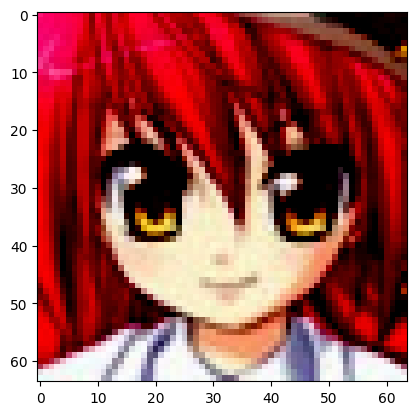

In [5]:
for img_batch, label_batch in dataloader:
    print('first batch')
    print(img_batch.shape)
    # 将 PyTorch 张量从[channels，height，width]的格式转换为[height，width，channels]的格式
    # 同时将[-1, 1]转为[0, 1]
    plt.imshow(torch.clamp(img_batch[0].permute(1, 2, 0), 0, 1))
    print(label_batch)
    break

In [6]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cpu


In [7]:
# 定义判别器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [8]:
# 定义生成器
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [9]:
# 初始化网络
z_dim = 100
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

In [10]:
# 定义损失函数和优化器
learning_rate = 0.01
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [11]:
sample_dir = './anime_samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

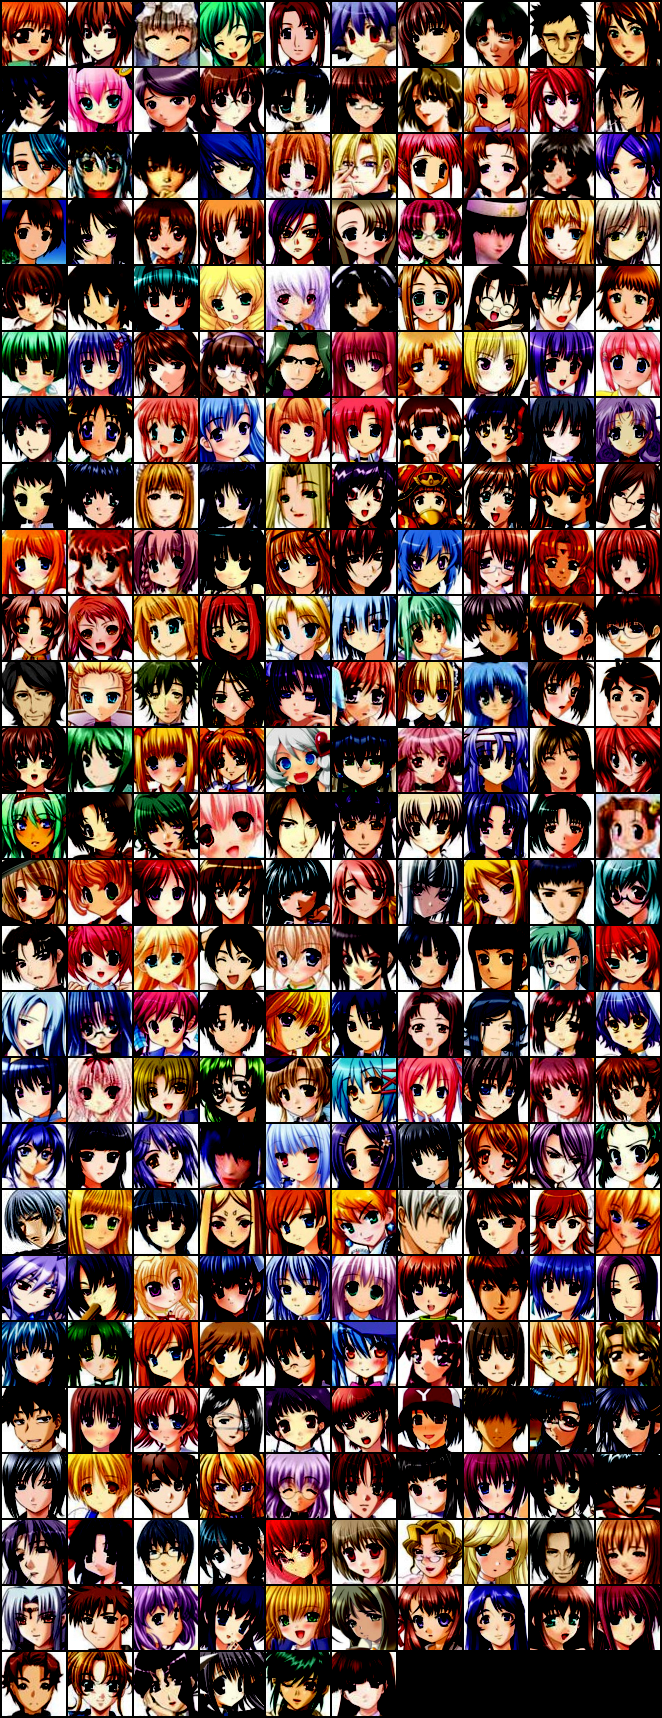

In [12]:
# Save some real images
from IPython.display import Image
from torchvision.utils import save_image
for images, _ in dataloader:
    save_image(images, os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


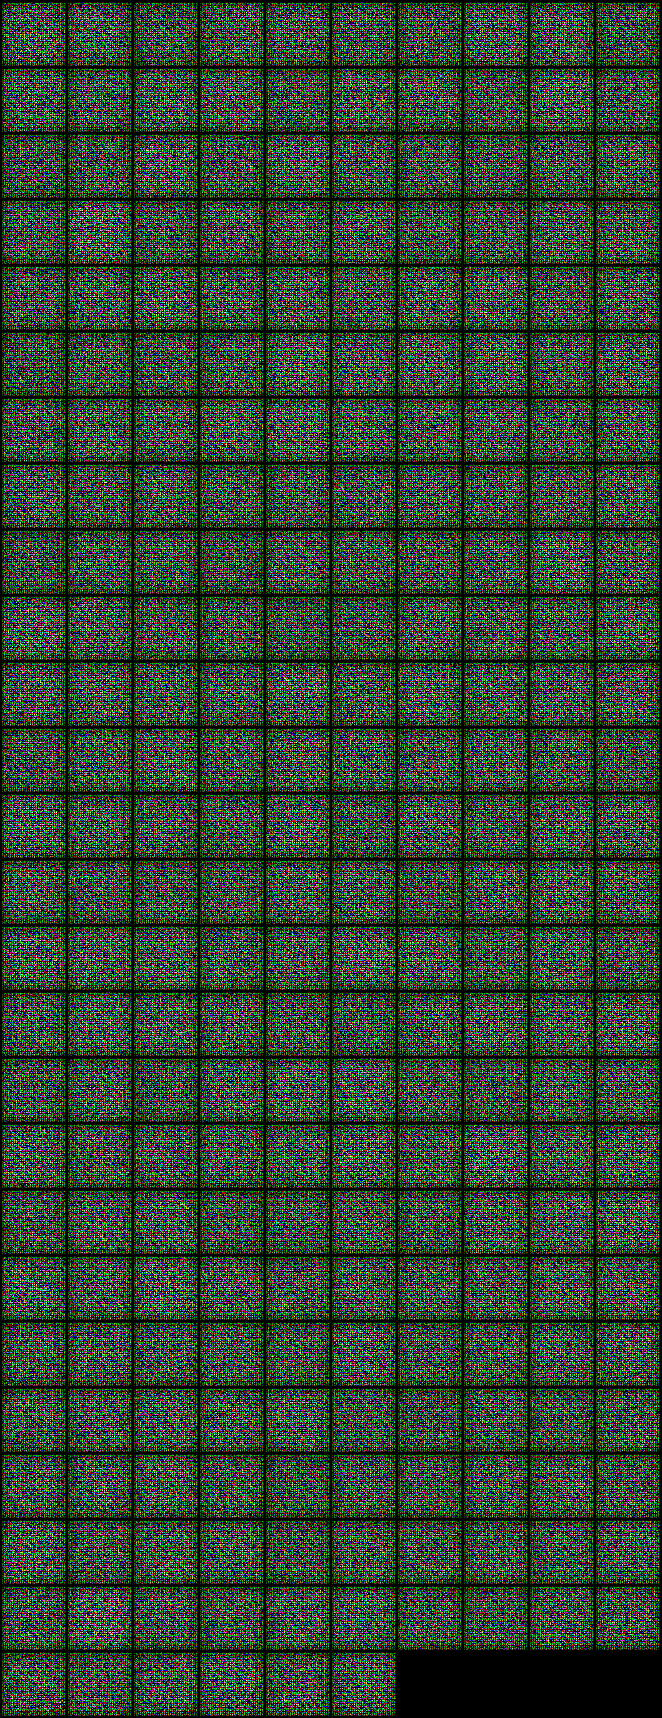

In [13]:
z = torch.randn(batch_size, z_dim, 1, 1).to(device)

def save_fake_images(index):
    fake_images = G(z)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(fake_images, os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [35]:
# 训练GAN
epochs = 5
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # 训练判别器
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        # 判别器在真图像上的损失
        outputs = D(real_images)
        real_labels = torch.ones_like(outputs)
        fake_labels = torch.zeros_like(outputs)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs.mean().item()
        # 判别器在假图像上的损失
        z = torch.randn(images.size(0), z_dim, 1, 1).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs.mean().item()
        # 总的判别器损失
        d_loss = d_loss_real + d_loss_fake
        # 反向传播和优化
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # 训练生成器
        z = torch.randn(images.size(0), z_dim, 1, 1).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        # 反向传播和优化
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()
        
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        if i % 100 == 0:
            print(f'Epoch {epoch}: batch{i}  real_score: {real_score}  fake_score  {fake_score}  dloss: {d_loss},  gloss: {g_loss}')

    # 保存生成的假图像   
    save_fake_images(epoch + 1) 
    print(f'Epoch [{epoch+1}/{epochs}]')

Epoch 0: batch0  real_score: 0.8895323872566223  fake_score  0.026634255424141884  dloss: 0.17129485309123993,  gloss: 5.997995853424072
Epoch 0: batch100  real_score: 0.4050499200820923  fake_score  0.03691358119249344  dloss: 1.1945772171020508,  gloss: 0.9494401216506958
Epoch 0: batch200  real_score: 0.9523172378540039  fake_score  0.3968506157398224  dloss: 0.5900534987449646,  gloss: 6.310516834259033
Epoch 0: batch300  real_score: 0.876902163028717  fake_score  0.3075086176395416  dloss: 0.5741461515426636,  gloss: 2.886533260345459
Saving fake_images-0001.png
Epoch [1/50]
Epoch 1: batch0  real_score: 0.8895323872566223  fake_score  0.026634255424141884  dloss: 0.17129485309123993,  gloss: 5.997995853424072
Epoch 1: batch100  real_score: 0.4050499200820923  fake_score  0.03691358119249344  dloss: 1.1945772171020508,  gloss: 0.9494401216506958
Epoch 1: batch200  real_score: 0.9523172378540039  fake_score  0.3968506157398224  dloss: 0.5900534987449646,  gloss: 6.310516834259033
Ep

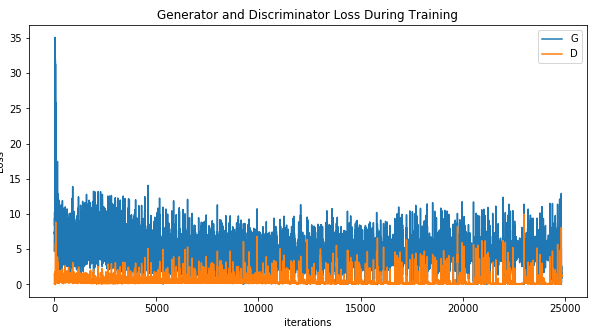

In [36]:
# plot loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

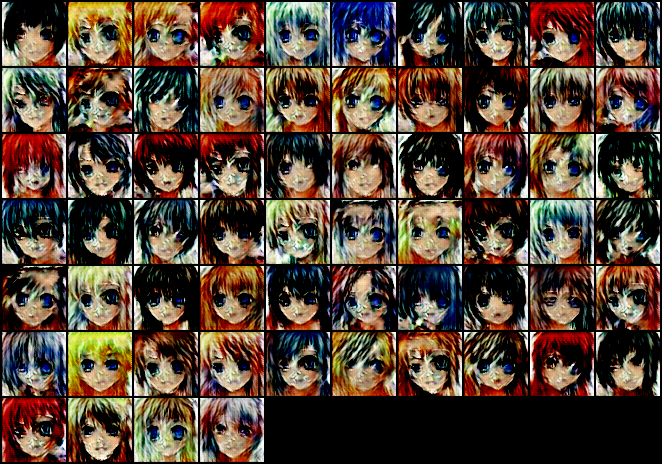

In [37]:
Image('./anime_samples/fake_images-0010.png')

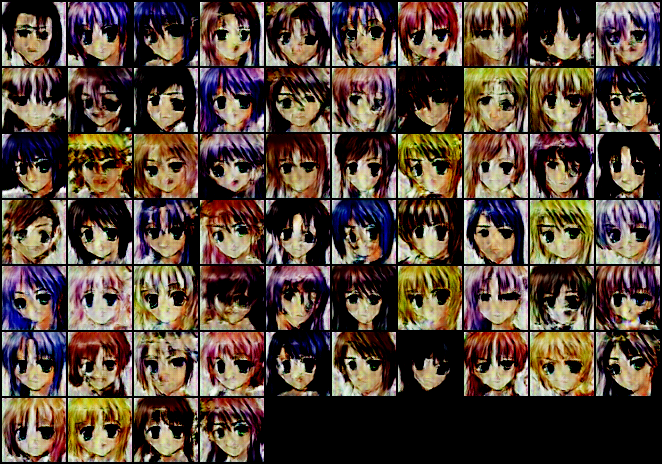

In [38]:
Image('./anime_samples/fake_images-0020.png')

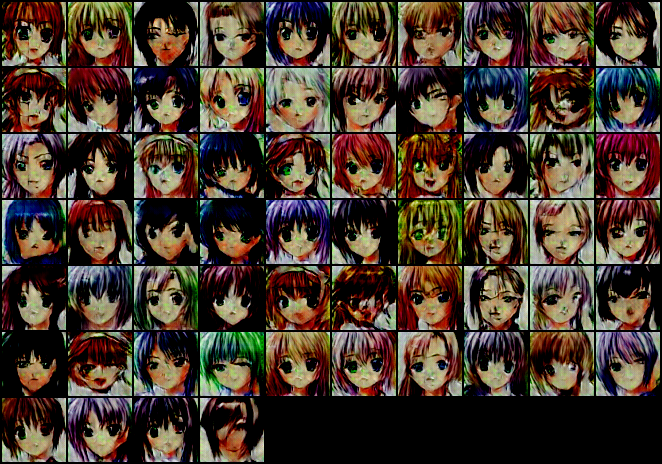

In [39]:
Image('./anime_samples/fake_images-0030.png')

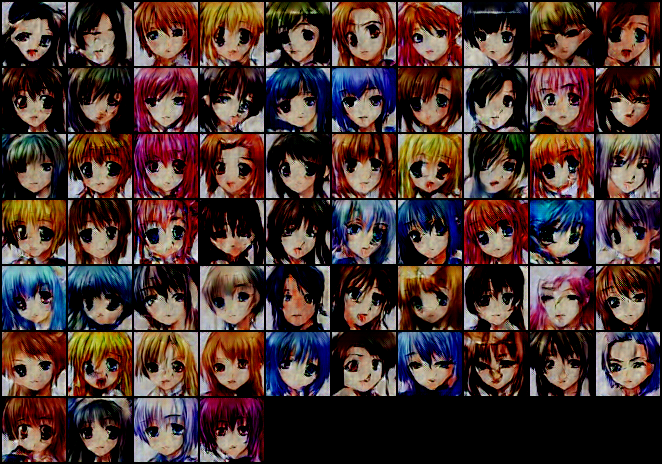

In [40]:
Image('./anime_samples/fake_images-0040.png')

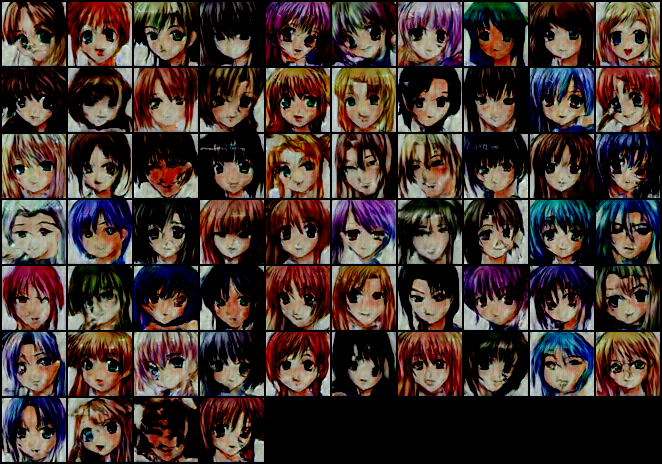

In [41]:
Image('./anime_samples/fake_images-0050.png')